# Problem 1 : Deep Q Learning : Preliminaries

### a) 
In the Walkins Q Learning algorithm, the Q(s,a) pairs are different and updating one of them doesn't affect the other which is not the case in Online Q Learning algorithm.

### b)
Updating the policy plays a key role here. After an iteration, the samples must be taken from the updated policy so that it will learn correctly.


# Problem 2 : Deep Q Learning : Programming


#### DQN and DDQN implementations of Mountain Car and Pong 
-> Couldn't train Pong completely because of the computational constraints. <br>
-> Learning curves for the performance of each model are shown. <br>
-> For the part (c) of this question, i have chosen the hyper-parameter as the replay buffer size <br>
-> For the part (d) of this question, I have done three seeds for the Mountain Car and couldn't do the same for pong because of the computational constraints. <br>
-> I am attaching the final checkpoints for all the models trained. <br>

In [4]:
import numpy as np
import os,random
import gym
from collections import deque
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Input,Conv2D,Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as ks
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def plot(scores,n):
    x = []
    y = []
    y_best = []
    n_scores = []
    for i in range(len(scores)):
        if (i+1)%n == 0:
            x.append((i//n)+1)
            y.append(np.mean(n_scores))
            y_best.append(np.max(n_scores))
            n_scores = []
        n_scores.append(scores[i])
        
    return x,y,y_best            

# DQN For MountainCar

In [4]:
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape
action_size = env.action_space.n
print(state_size)
print(action_size)

(2,)
3


In [5]:
env.reset()
done = False
while not done:
    action = np.random.randint(action_size)
    _,reward,done,_ = env.step(action)
    print(reward)

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


The reward is $-1$ for every step the car takes and a maximum of $200$ steps allowed. So a score of $-200$ in the worst case is possible.

In [7]:
class DQNAgent:
    def __init__(self,buffer_size,gamma,alpha,batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.95
        self.replay_buffer = deque(maxlen = buffer_size)
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())
        
    def build_model(self):
        model = Sequential()
        model.add(Dense(40,activation='relu',input_shape=self.state_size))
        model.add(Dense(40,activation='relu'))
        model.add(Dense(self.action_size,activation='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.alpha))
        return model
    
    def chose_action(self,state):
        self.epsilon = max(self.epsilon_min,self.epsilon)
        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(self.action_size)
        else:
            action = np.argmax(self.model.predict(state)[0])
        return action
    
    def replay(self):
        if len(self.replay_buffer)<self.batch_size:
            return
        batch = random.sample(self.replay_buffer,self.batch_size)
        
        states = []
        next_states = []
        for item in batch:
            state,action,reward,next_state,done = item
            states.append(state)
            next_states.append(next_state)
        
        states = np.array(states).reshape(self.batch_size,2)
        next_states = np.array(next_states).reshape(self.batch_size,2)
        
        targets = self.model.predict(states)
        next_state_targets = self.target_model.predict(next_states)
        
        for i,item in enumerate(batch):
            state,action,reward,next_state,done = item
            if done:
                targets[i][action] = reward
            else:
                next_Q_max = max(next_state_targets[i])
                targets[i][action] = reward + self.gamma*next_Q_max
            
        self.model.fit(states,targets,epochs=1,verbose=0)
        
    def train(self,num_episodes,save_flag):
        print('------- Training -------')
        scores = []
        for episode in range(num_episodes):
            print('Episode',episode)
            state = env.reset().reshape(1,2)
            score = 0
            done = False
            while not done:
                action = self.chose_action(state)
                next_state,reward,done,_ = env.step(action)
                next_state = next_state.reshape(1,2)
                if next_state[0][0] >= 0.5:
                    reward = 10
                self.replay_buffer.append([state,action,reward,next_state,done])
                self.replay()
                state = next_state
                score += reward
                
            self.target_model.set_weights(self.model.get_weights())    
            env.close()  
            self.epsilon *= self.epsilon_decay
            scores.append(score)
            
            if save_flag and (episode+1)%10 == 0:
                self.save(episode+1)
                
            
        print('------- Finished Training -------')
        return scores
                               
    def load(self,episode):
        self.model.load_weights('Checkpoints-MountainCar-DQN/'+str(episode)+'-dqn.h5')
        self.target_model.set_weights(self.model.get_weights())
        
    def save(self,episode):
        if not os.path.exists('Checkpoints-MountainCar-DQN'):
            os.mkdir('Checkpoints-MountainCar-DQN')
        self.model.save_weights('Checkpoints-MountainCar-DQN/'+str(episode)+'-dqn.h5')
        
    def test(self,num_episodes,render_flag):
        print('------- Testing -------')
        wins = 0
        scores = []
        for episode in range(num_episodes):
            state = env.reset().reshape(1,2)
            score = 0
            done = False
            while not done:
                action = np.argmax(self.model.predict(state)[0])
                next_state,reward,done,_ = env.step(action)
                if render_flag:
                    env.render()
                next_state = next_state.reshape(1,2)
                if next_state[0][0] >= 0.5:
                    reward = 10
                    wins += 1
                score += reward
                state = next_state
            scores.append(score)
            env.close()
            
        print('\tWon {} out of {} games'.format(wins,num_episodes))
        print('\tAverage Score : {}'.format(np.mean(scores)))
        


In [69]:
agent_dqn = DQNAgent(20000,0.99,0.001,32)

In [5]:
scores_dqn = agent_dqn.train(500,True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 7

In [6]:
# Loading the final model from the folder. Just pass the number as parameter
# Testing for 50 games.
agent_dqn.load(500)
agent_dqn.test(50,False)

------- Testing -------
	Won 50 out of 50 games
	Average Score : -118.64


In [71]:
# Loading the final model from the folder. Just pass the number as parameter
# For seeing the agent in action.
agent_dqn.load(500)
agent_dqn.test(1,True)

------- Testing -------
	Won 1 out of 1 games
	Average Score : -75.0


In [7]:
x_dqn,y_dqn,y_best_dqn = plot(scores_dqn,20)

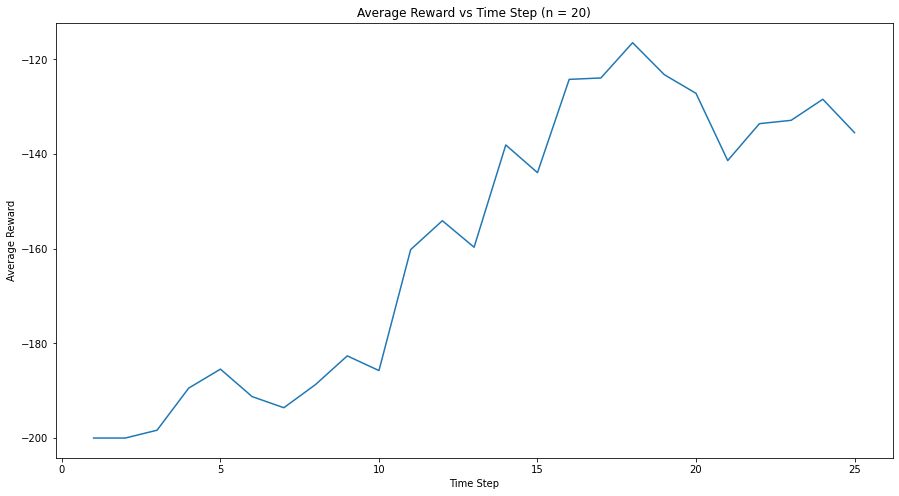

In [8]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_dqn)
plt.title('Average Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.show()

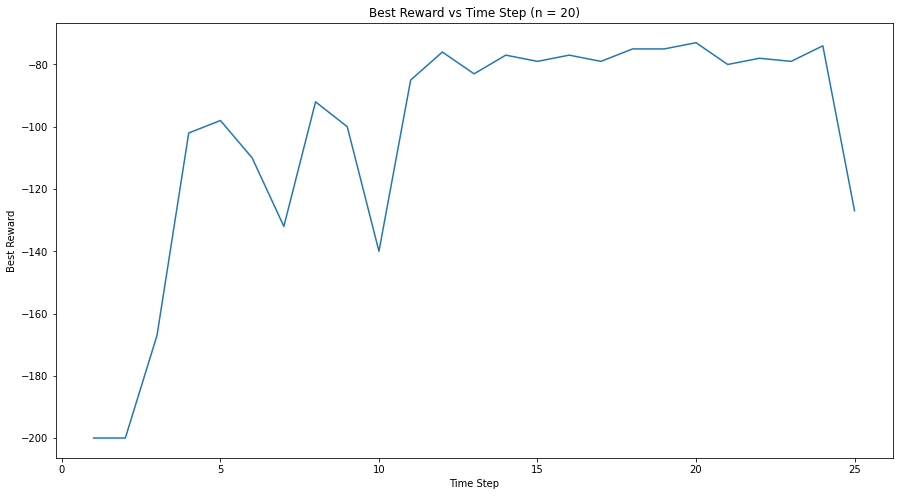

In [9]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_best_dqn)
plt.title('Best Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Best Reward')
plt.show()

In [12]:
agent1 = DQNAgent(40,0.99,0.001,32)
scores_40 = agent1.train(500,False)

------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episod

In [13]:
agent2 = DQNAgent(200,0.99,0.001,32)
scores_200 = agent2.train(500,False)

------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episod

In [14]:
agent3 = DQNAgent(2000,0.99,0.001,32)
scores_2000 = agent3.train(500,False)

------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episod

In [15]:
x_40,y_40,y_best_40 = plot(scores_40,20)
x_200,y_200,y_best_200 = plot(scores_200,20)
x_2000,y_2000,y_best_2000 = plot(scores_2000,20)

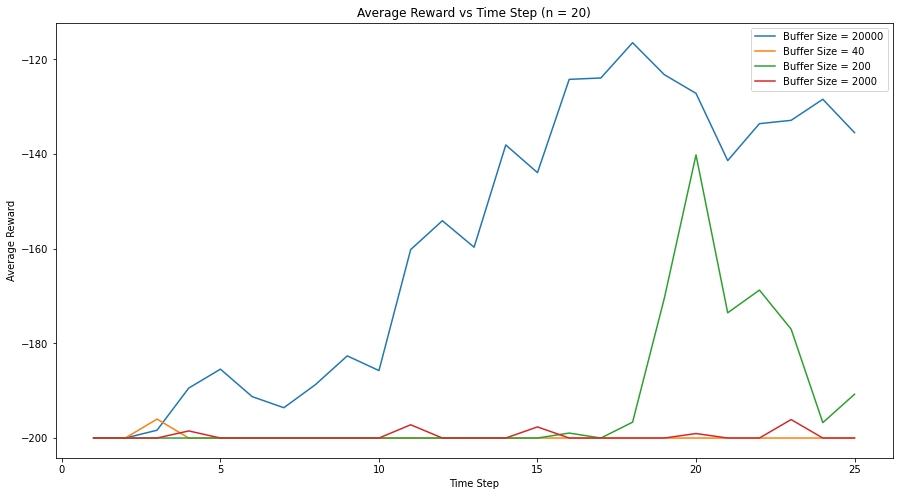

In [16]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_dqn,label = 'Buffer Size = 20000')
plt.plot(x_40,y_40,label = 'Buffer Size = 40')
plt.plot(x_200,y_200,label = 'Buffer Size = 200')
plt.plot(x_2000,y_2000,label = 'Buffer Size = 2000')
plt.title('Average Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

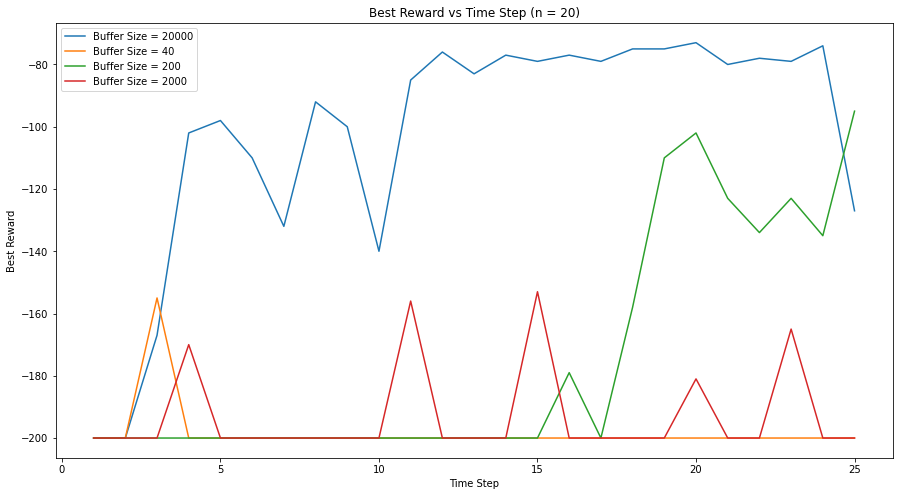

In [17]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_best_dqn,label = 'Buffer Size = 20000')
plt.plot(x_40,y_best_40,label = 'Buffer Size = 40')
plt.plot(x_200,y_best_200,label = 'Buffer Size = 200')
plt.plot(x_2000,y_best_2000,label = 'Buffer Size = 2000')
plt.title('Best Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Best Reward')
plt.legend()
plt.show()

# DDQN For MountainCar

In [8]:
class DDQNAgent:
    def __init__(self,buffer_size,gamma,alpha,batch_size):
        self.state_size = env.observation_space.shape
        self.action_size = env.action_space.n
        self.gamma = gamma
        self.alpha = alpha
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.95
        self.replay_buffer = deque(maxlen = buffer_size)
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())
        
    def build_model(self):
        model = Sequential()
        model.add(Dense(40,activation='relu',input_shape=self.state_size))
        model.add(Dense(40,activation='relu'))
        model.add(Dense(self.action_size,activation='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.alpha))
        return model
    
    def chose_action(self,state):
        self.epsilon = max(self.epsilon_min,self.epsilon)
        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(3)
        else:
            action = np.argmax(self.model.predict(state)[0])
        return action
    
    def replay(self):
        if len(self.replay_buffer)<self.batch_size:
            return
        batch = random.sample(self.replay_buffer,self.batch_size)
        
        states = []
        next_states = []
        for item in batch:
            state,action,reward,next_state,done = item
            states.append(state)
            next_states.append(next_state)
        
        states = np.array(states).reshape(self.batch_size,2)
        next_states = np.array(next_states).reshape(self.batch_size,2)
        
        targets = self.model.predict(states)
        targets_next = self.model.predict(next_states)
        next_state_targets = self.target_model.predict(next_states)
        
        for i,item in enumerate(batch):
            state,action,reward,next_state,done = item
            if done:
                targets[i][action] = reward
            else:
                a = np.argmax(targets_next[i])
                targets[i][action] = reward + self.gamma*next_state_targets[i][a]
            
        self.model.fit(states,targets,epochs=1,verbose=0)
        
    def train(self,num_episodes,save_flag):
        print('------- Training -------')
        scores = []
        for episode in range(num_episodes):
            print('Episode',episode)
            state = env.reset().reshape(1,2)
            score = 0
            done = False
            while not done:
                action = self.chose_action(state)
                next_state,reward,done,_ = env.step(action)
                next_state = next_state.reshape(1,2)
                if next_state[0][0] >= 0.5:
                    reward = 10
                self.replay_buffer.append([state,action,reward,next_state,done])
                self.replay()
                state = next_state
                score += reward
                
            self.target_model.set_weights(self.model.get_weights())    
            env.close()  
            self.epsilon *= self.epsilon_decay
            scores.append(score)
            
            if save_flag and (episode+1)%10 == 0:
                self.save(episode+1)
                
            
        print('------- Finished Training -------')
        return scores
                               
    def load(self,episode):
        self.model.load_weights('Checkpoints-MountainCar-DDQN/'+str(episode)+'-ddqn.h5')
        self.target_model.set_weights(self.model.get_weights())
        
    def save(self,episode):
        if not os.path.exists('Checkpoints-MountainCar-DDQN'):
            os.mkdir('Checkpoints-MountainCar-DDQN')
        self.model.save_weights('Checkpoints-MountainCar-DDQN/'+str(episode)+'-ddqn.h5')
        
    def test(self,num_episodes,render_flag):
        print('------- Testing -------')
        wins = 0
        scores = []
        for episode in range(num_episodes):
            state = env.reset().reshape(1,2)
            score = 0
            done = False
            while not done:
                action = np.argmax(self.model.predict(state)[0])
                next_state,reward,done,_ = env.step(action)
                if render_flag:
                    env.render()
                next_state = next_state.reshape(1,2)
                if next_state[0][0] >= 0.5:
                    reward = 10
                    wins += 1
                score += reward
                state = next_state
            scores.append(score)
            env.close()
            
        print('\tWon {} out of {} games'.format(wins,num_episodes))
        print('\tAverage Score : {}'.format(np.mean(scores)))
        


In [73]:
agent_ddqn = DDQNAgent(20000,0.99,0.001,32)

In [19]:
scores_ddqn = agent_ddqn.train(500,True)

------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episod

In [24]:
# Loading the final model from the folder. Just pass the number as parameter
# Testing for 50 games.
agent_ddqn.load(500)
agent_ddqn.test(50,False)

------- Testing -------
	Won 50 out of 50 games
	Average Score : -133.88


In [74]:
# Loading the final model from the folder. Just pass the number as parameter
# For seeing the agent in action.
agent_ddqn.load(500)
agent_ddqn.test(1,True)

------- Testing -------
	Won 1 out of 1 games
	Average Score : -125.0


In [21]:
x_ddqn,y_ddqn,y_best_ddqn = plot(scores_ddqn,20)

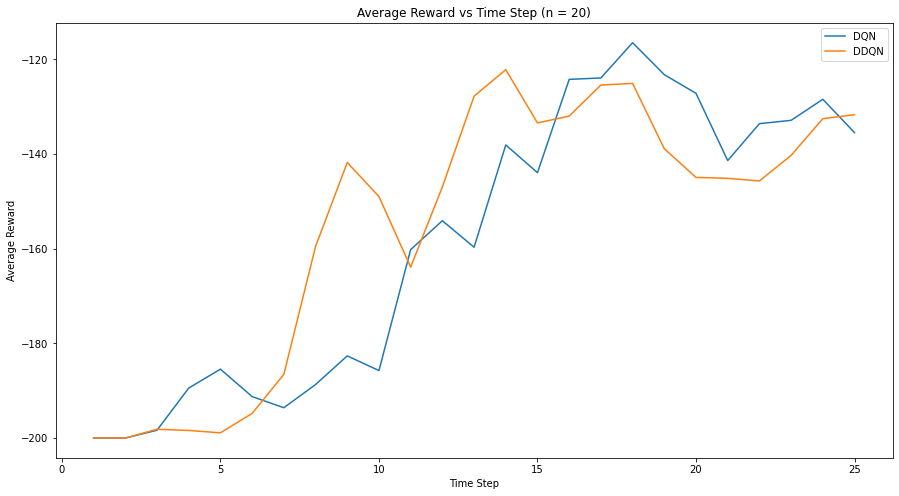

In [22]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_dqn,label = 'DQN')
plt.plot(x_ddqn,y_ddqn,label = 'DDQN')
plt.title('Average Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

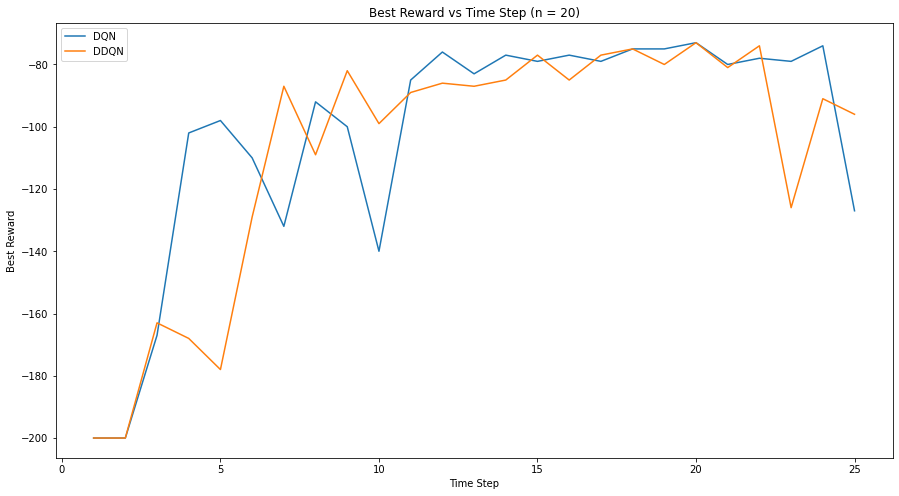

In [23]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_best_dqn,label = 'DQN')
plt.plot(x_ddqn,y_best_ddqn,label = 'DDQN')
plt.title('Best Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Best Reward')
plt.legend()
plt.show()

In [5]:
env.seed(100)

[100]

In [10]:
agent_dqn = DQNAgent(20000,0.99,0.001,32)
agent_ddqn = DDQNAgent(20000,0.99,0.001,32)

In [11]:
scores_dqn = agent_dqn.train(500,False)
scores_ddqn = agent_ddqn.train(500,False)

------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episod

Episode 195
Episode 196
Episode 197
Episode 198
Episode 199
Episode 200
Episode 201
Episode 202
Episode 203
Episode 204
Episode 205
Episode 206
Episode 207
Episode 208
Episode 209
Episode 210
Episode 211
Episode 212
Episode 213
Episode 214
Episode 215
Episode 216
Episode 217
Episode 218
Episode 219
Episode 220
Episode 221
Episode 222
Episode 223
Episode 224
Episode 225
Episode 226
Episode 227
Episode 228
Episode 229
Episode 230
Episode 231
Episode 232
Episode 233
Episode 234
Episode 235
Episode 236
Episode 237
Episode 238
Episode 239
Episode 240
Episode 241
Episode 242
Episode 243
Episode 244
Episode 245
Episode 246
Episode 247
Episode 248
Episode 249
Episode 250
Episode 251
Episode 252
Episode 253
Episode 254
Episode 255
Episode 256
Episode 257
Episode 258
Episode 259
Episode 260
Episode 261
Episode 262
Episode 263
Episode 264
Episode 265
Episode 266
Episode 267
Episode 268
Episode 269
Episode 270
Episode 271
Episode 272
Episode 273
Episode 274
Episode 275
Episode 276
Episode 277
Epis

In [12]:
x_dqn,y_dqn,y_best_dqn = plot(scores_dqn,20)
x_ddqn,y_ddqn,y_best_ddqn = plot(scores_ddqn,20)

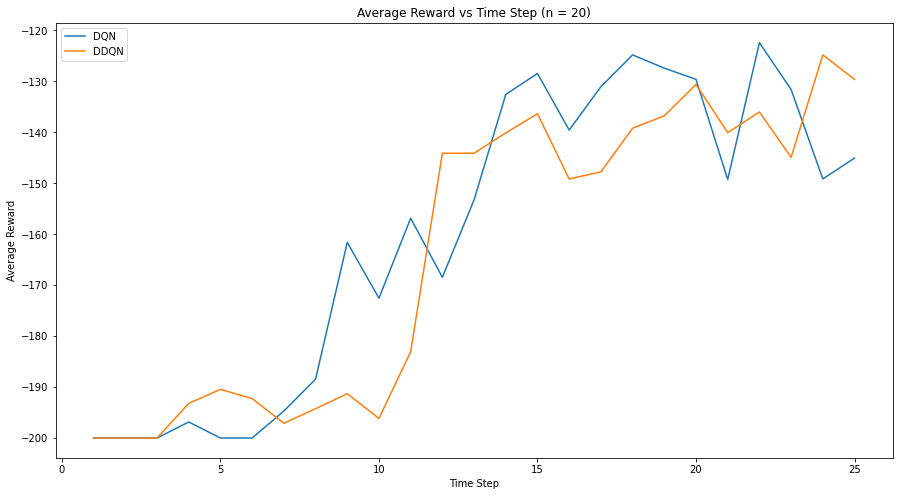

In [13]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_dqn,label = 'DQN')
plt.plot(x_ddqn,y_ddqn,label = 'DDQN')
plt.title('Average Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

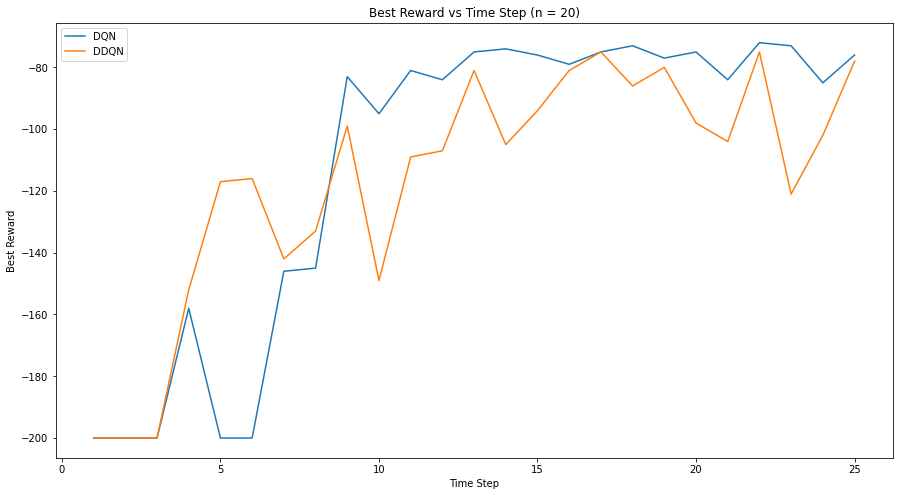

In [14]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_best_dqn,label = 'DQN')
plt.plot(x_ddqn,y_best_ddqn,label = 'DDQN')
plt.title('Best Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Best Reward')
plt.legend()
plt.show()

In [15]:
env.seed(200)

[200]

In [16]:
agent_dqn = DQNAgent(20000,0.99,0.001,32)
agent_ddqn = DDQNAgent(20000,0.99,0.001,32)

In [17]:
scores_dqn = agent_dqn.train(500,False)
scores_ddqn = agent_ddqn.train(500,False)

------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episod

Episode 195
Episode 196
Episode 197
Episode 198
Episode 199
Episode 200
Episode 201
Episode 202
Episode 203
Episode 204
Episode 205
Episode 206
Episode 207
Episode 208
Episode 209
Episode 210
Episode 211
Episode 212
Episode 213
Episode 214
Episode 215
Episode 216
Episode 217
Episode 218
Episode 219
Episode 220
Episode 221
Episode 222
Episode 223
Episode 224
Episode 225
Episode 226
Episode 227
Episode 228
Episode 229
Episode 230
Episode 231
Episode 232
Episode 233
Episode 234
Episode 235
Episode 236
Episode 237
Episode 238
Episode 239
Episode 240
Episode 241
Episode 242
Episode 243
Episode 244
Episode 245
Episode 246
Episode 247
Episode 248
Episode 249
Episode 250
Episode 251
Episode 252
Episode 253
Episode 254
Episode 255
Episode 256
Episode 257
Episode 258
Episode 259
Episode 260
Episode 261
Episode 262
Episode 263
Episode 264
Episode 265
Episode 266
Episode 267
Episode 268
Episode 269
Episode 270
Episode 271
Episode 272
Episode 273
Episode 274
Episode 275
Episode 276
Episode 277
Epis

In [18]:
x_dqn,y_dqn,y_best_dqn = plot(scores_dqn,20)
x_ddqn,y_ddqn,y_best_ddqn = plot(scores_ddqn,20)

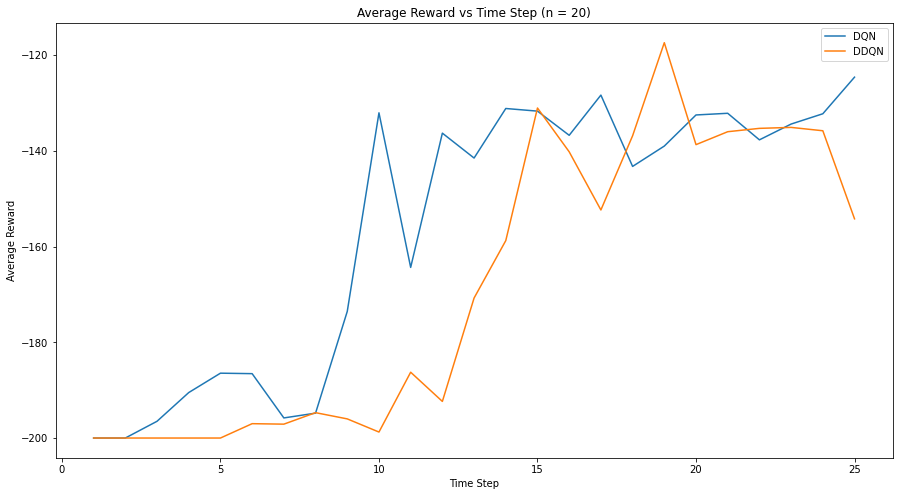

In [19]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_dqn,label = 'DQN')
plt.plot(x_ddqn,y_ddqn,label = 'DDQN')
plt.title('Average Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

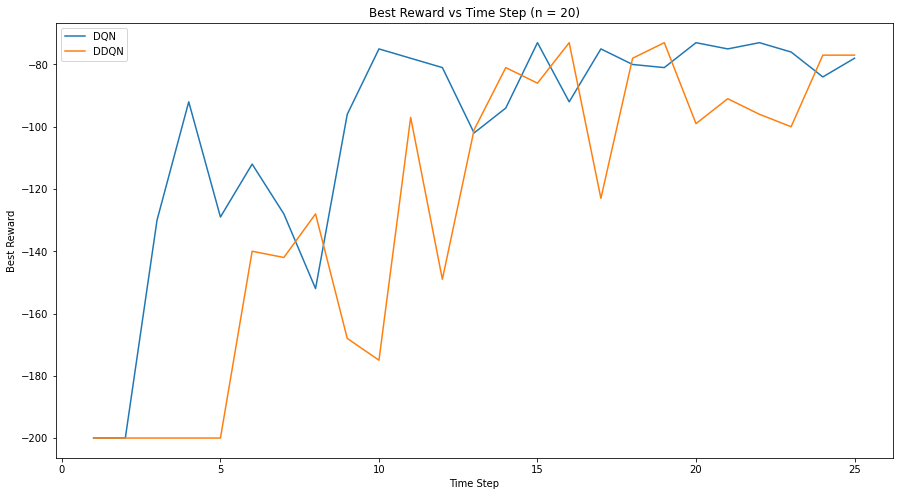

In [20]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_best_dqn,label = 'DQN')
plt.plot(x_ddqn,y_best_ddqn,label = 'DDQN')
plt.title('Best Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Best Reward')
plt.legend()
plt.show()

# DQN for Pong

In [5]:
env = gym.make('Pong-v0')
state_size = env.observation_space.shape
action_size = env.action_space.n
print(state_size)
print(action_size)

(210, 160, 3)
6


In [6]:
env.reset()
done = False
while not done:
    action = np.random.randint(action_size)
    _,reward,done,_ = env.step(action)
    print(reward)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


The reward is $+1$ for every point our player scores and $-1$ for every point the opponent scores. The game is for $21$ points. So the maximum possible score is $21$ and the least possible score is $-21$. 

In [12]:
class DQNAgent:
    def __init__(self,buffer_size,gamma,alpha,batch_size):
        self.state_size = (80,80,4)
        self.action_size = env.action_space.n
        
        self.replay_buffer = deque(maxlen = buffer_size)
        self.gamma = gamma
        self.alpha = alpha
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.95
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())
        
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32,8,padding='same',strides=4,activation='relu',input_shape=self.state_size))
        model.add(Conv2D(64,4,padding='same',strides=2,activation='relu'))
        model.add(Conv2D(128,4,padding='same',strides=2,activation='relu'))
        model.add(Flatten())
        model.add(Dense(512,activation='relu'))
        model.add(Dense(256,activation='relu'))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(self.action_size,activation='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.alpha))
        return model
    
    def chose_action(self,state):
        self.epsilon = max(self.epsilon_min,self.epsilon)
        if np.random.rand(1) < self.epsilon:
            action = env.action_space.sample()
        else:
            state = np.expand_dims(state,axis=0)
            action = np.argmax(self.model.predict(state)[0])
        return action
    
    def replay(self):
        if len(self.replay_buffer)<self.batch_size:
            return
        batch = random.sample(self.replay_buffer,self.batch_size)
        
        states = []
        next_states = []
        for item in batch:
            state,action,reward,next_state,done = item
            states.append(state)
            next_states.append(next_state)
        
        states = np.array(states)
        next_states = np.array(next_states)
        targets = self.model.predict(states)
        next_state_targets = self.target_model.predict(next_states)
        
        for i,item in enumerate(batch):
            state,action,reward,next_state,done = item
            if done:
                targets[i][action] = reward
            else:
                next_Q_max = max(next_state_targets[i])
                targets[i][action] = reward + self.gamma*next_Q_max
            
        self.model.fit(states,targets,epochs=1,verbose=0)
                  
    def stack_states(self,stack,state):
        state = cv2.cvtColor(state,cv2.COLOR_BGR2GRAY)
        state = cv2.resize(state,(80,80),interpolation = cv2.INTER_AREA)
        state = state/255
        stack.append(state)
        states = np.stack(stack,axis=2)
        return states
        
        
    def train(self,num_episodes,save_flag):
        print('------- Training -------')
        if save_flag:
            self.save('start')
        scores = []
        for episode in range(num_episodes):
            print('Episode',episode)
            state = env.reset()
            done = False
            states_stack = deque([np.zeros((80,80)) for _ in range(4)],maxlen = 4)
            states = self.stack_states(states_stack,state)
            prev_states_stack = deque([np.zeros((80,80)) for _ in range(4)],maxlen = 4)
            score = 0
            step = 0
            while not done:
                action = self.chose_action(states)
                next_state,reward,done,_ = env.step(action)
                states = self.stack_states(states_stack,next_state)
                prev_states = self.stack_states(prev_states_stack,state)
                self.replay_buffer.append([prev_states,action,reward,states,done])
                self.replay()
                state = next_state
                score += reward
                step += 1

            self.target_model.set_weights(self.model.get_weights())
            env.close()  
            self.epsilon *= self.epsilon_decay
            scores.append(score)
            if episode > 0 and save_flag and (episode+1)%10==0:
                self.save(episode)
            
        print('------- Finished Training -------')
        if save_flag:
            self.save('final')
        return scores
                
                    
    def load(self,episode):
        self.model.load_weights('Checkpoints-Pong/'+str(episode)+'-dqn.h5')
        self.target_model.set_weights(self.model.get_weights())
        
    def save(self,episode):
        if not os.path.exists('Checkpoints-Pong'):
            os.mkdir('Checkpoints-Pong')
        self.model.save_weights('Checkpoints-Pong/'+str(episode)+'-dqn.h5')
        
    def test(self,num_episodes,render_flag):
        print('------- Testing -------')
        scores = []
        for episode in range(num_episodes):
            state = env.reset()
            done = False
            states_stack = deque([np.zeros((80,80)) for _ in range(4)],maxlen = 4)
            states = self.stack_states(states_stack,state)
            score = 0
            while not done:
                temp = np.expand_dims(states,axis=0)
                action = np.argmax(self.model.predict(temp)[0])
                next_state,reward,done,_ = env.step(action)
                states = self.stack_states(states_stack,next_state)
                if render_flag:
                    env.render()
                score += reward

            scores.append(score)
            env.close()
            
        print('\tAverage Score : {} over {} games.'.format(np.mean(scores),num_episodes))
        return np.mean(scores)


In [14]:
agent = DQNAgent(50000,0.99,1e-5,64)

In [ ]:
scores = agent.train(2000,True)

In [ ]:
# Loading the final model from the folder. Just pass the number as parameter
# Testing for 50 games.
agent.load(700)
agent.test(50,False)

In [ ]:
# Loading the last model from the folder. Just pass the number as parameter
# For seeing the agent in action.
agent.load(700)
agent.test(1,True)

In [22]:
x_dqn,y_dqn,y_best_dqn = plot(scores,20)

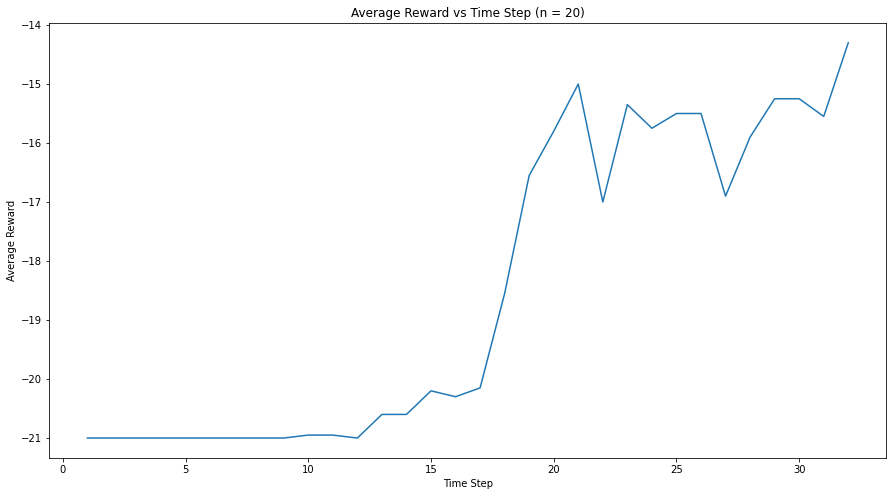

In [23]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_dqn)
plt.title('Average Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.show()

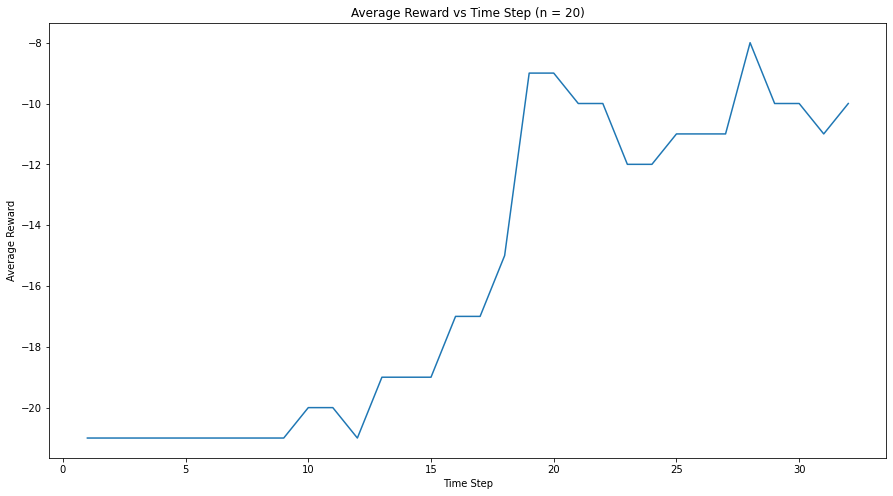

In [24]:
plt.figure(figsize=(15,8))
plt.plot(x_dqn,y_best_dqn)
plt.title('Best Reward vs Time Step (n = 20)')
plt.xlabel('Time Step')
plt.ylabel('Best Reward')
plt.show()

# Problem 3 : Policy Gradient

#### PG implementations of Cartpole and Lunar Lander 
-> PGAgent1 is an agent with reward to go and advantage normalization functionality. <br>
-> PGAgent2 is an agent without reward to go and advantage normalization functionality. <br>
-> Learning curves for the performance of each model are shown. <br>
-> I am attaching the final checkpoints for all the models trained. <br>

In [6]:
class PGAgent1:
    def __init__(self,state_size,action_size,gamma,alpha,n_hidden_1,n_hidden_2,name):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.name = name
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.baseline = []
        
        self.model,self.predict = self.build_model(n_hidden_1,n_hidden_2)
        
    def build_model(self,n_hidden_1,n_hidden_2):
        input_ = Input(shape=self.state_size)
        advantages = Input(shape=[1])
        l1 = Dense(n_hidden_1,activation='relu')(input_)
        l2 = Dense(n_hidden_2,activation='relu')(l1)
        out = Dense(self.action_size,activation='softmax')(l2)
        
        def custom_loss(y_true,y_pred):
            prob = ks.clip(y_pred,1e-8,1-1e-8)
            log_lik = y_true*ks.log(prob)
            return ks.sum(-log_lik*advantages)
        
        model = Model(inputs=[input_,advantages],outputs=[out])
        model.compile(loss=custom_loss,optimizer=Adam(lr=self.alpha))
        
        predict = Model(inputs=[input_],outputs=[out])
        return model,predict
        
    def chose_action(self,state):
        state = np.expand_dims(state,axis=0)
        prob = self.predict.predict(state)[0]
        action = np.random.choice(np.arange(self.action_size),p=prob)
        return action
        
    def replay(self):
        state_memory = np.array(self.state_memory)
        action_memory = np.array(self.action_memory)
        reward_memory = np.array(self.reward_memory)
        
        actions = np.zeros((len(action_memory),self.action_size))
        actions[np.arange(len(action_memory)),action_memory] = 1
        
        reward_to_go = np.zeros_like(reward_memory)
        for t in range(len(reward_memory)):
            G_sum = 0
            discount = 1
            for tt in range(t,len(reward_memory)):
                G_sum += reward_memory[tt]*discount
                discount *= self.gamma
            reward_to_go[t] = G_sum
        
        self.baseline.append(reward_to_go[0])
        advantage = reward_to_go - np.mean(self.baseline)
        mean = np.mean(advantage)
        std = np.std(advantage) if np.std(advantage)>0 else 1
        advantage = (advantage-mean)/std
        self.model.train_on_batch([state_memory,advantage],actions)
        
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        
    def train(self,num_episodes,save_flag):
        print('------- Training -------')
        scores = []
        for episode in range(num_episodes):
            print('Episode',episode)
            state = env.reset()
            done = False
            score = 0
            while not done:
                action = self.chose_action(state)
                next_state,reward,done,_ = env.step(action)
                self.state_memory.append(state)
                self.action_memory.append(action)
                self.reward_memory.append(reward)
                state = next_state
                score += reward
            
            env.close()
            scores.append(score)
            self.replay()
            if save_flag and (episode+1)%50 == 0:
                self.save(episode+1)
                
        print('------- Finished Training -------')
        return scores
                
    def load(self,episode):
        self.model.load_weights('Checkpoints-'+self.name+'-PG-1/'+str(episode)+'-pg.h5')
        
    def save(self,episode):
        if not os.path.exists('Checkpoints-'+self.name+'-PG-1'):
            os.mkdir('Checkpoints-'+self.name+'-PG-1')
        self.model.save_weights('Checkpoints-'+self.name+'-PG-1/'+str(episode)+'-pg.h5')
        
    def test(self,num_episodes,render_flag):
        print('------- Testing -------')
        scores = []
        for episode in range(num_episodes):
            state = env.reset()
            score = 0
            done = False
            while not done:
                action = self.chose_action(state)
                next_state,reward,done,_ = env.step(action)
                if render_flag:
                    env.render()
                score += reward
                state = next_state
            scores.append(score)
            env.close()
            
        print('\tAverage Score : {}'.format(np.mean(scores)))
            

In [7]:
class PGAgent2:
    def __init__(self,state_size,action_size,gamma,alpha,n_hidden_1,n_hidden_2,name):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.name = name
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        
        self.model,self.predict = self.build_model(n_hidden_1,n_hidden_2)
        
    def build_model(self,n_hidden_1,n_hidden_2):
        input_ = Input(shape=self.state_size)
        advantages = Input(shape=[1])
        l1 = Dense(n_hidden_1,activation='relu')(input_)
        l2 = Dense(n_hidden_2,activation='relu')(l1)
        out = Dense(self.action_size,activation='softmax')(l2)
        
        def custom_loss(y_true,y_pred):
            prob = ks.clip(y_pred,1e-8,1-1e-8)
            log_lik = y_true*ks.log(prob)
            return ks.sum(-log_lik*advantages)
        
        model = Model(inputs=[input_,advantages],outputs=[out])
        model.compile(loss=custom_loss,optimizer=Adam(lr=self.alpha))
        
        predict = Model(inputs=[input_],outputs=[out])
        return model,predict
        
    def chose_action(self,state):
        state = np.expand_dims(state,axis=0)
        prob = self.predict.predict(state)[0]
        action = np.random.choice(np.arange(self.action_size),p=prob)
        return action
        
    def replay(self):
        state_memory = np.array(self.state_memory)
        action_memory = np.array(self.action_memory)
        reward_memory = np.array(self.reward_memory)
        
        actions = np.zeros((len(action_memory),self.action_size))
        actions[np.arange(len(action_memory)),action_memory] = 1
        
        advantage = np.zeros_like(reward_memory)
        G_sum = 0
        discount = 1
        for t in range(len(reward_memory)):
            G_sum += reward_memory[t]*discount
            discount *= self.gamma

        advantage.fill(G_sum)
        self.model.train_on_batch([state_memory,advantage],actions)
        
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        
    def train(self,num_episodes,save_flag):
        print('------- Training -------')
        scores = []
        for episode in range(num_episodes):
            print('Episode',episode)
            state = env.reset()
            done = False
            score = 0
            while not done:
                action = self.chose_action(state)
                next_state,reward,done,_ = env.step(action)
                self.state_memory.append(state)
                self.action_memory.append(action)
                self.reward_memory.append(reward)
                state = next_state
                score += reward
            
            env.close()
            scores.append(score)
            self.replay()
            if save_flag and (episode+1)%50 == 0:
                self.save(episode+1)
                
        print('------- Finished Training -------')
        return scores
                
    def load(self,episode):
        self.model.load_weights('Checkpoints-'+self.name+'-PG-2/'+str(episode)+'-pg.h5')
        
    def save(self,episode):
        if not os.path.exists('Checkpoints-'+self.name+'-PG-2'):
            os.mkdir('Checkpoints-'+self.name+'-PG-2')
        self.model.save_weights('Checkpoints-'+self.name+'-PG-2/'+str(episode)+'-pg.h5')
        
    def test(self,num_episodes,render_flag):
        print('------- Testing -------')
        scores = []
        for episode in range(num_episodes):
            state = env.reset()
            score = 0
            done = False
            while not done:
                action = self.chose_action(state)
                next_state,reward,done,_ = env.step(action)
                if render_flag:
                    env.render()
                score += reward
                state = next_state
            scores.append(score)
            env.close()
            
        print('\tAverage Score : {}'.format(np.mean(scores)))
            

# Policy Gradients : Cartpole

In [6]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape
action_size = env.action_space.n
print(state_size)
print(action_size)

(4,)
2


In [7]:
env.reset()
done = False
while not done:
    action = np.random.randint(action_size)
    _,reward,done,_ = env.step(action)
    print(reward)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


The reward is $+1$ for every step it survive and a maximum of $500$ steps allowed. So a score of $500$ in the best case is possible.

In [115]:
agent_cartpole_1 = PGAgent1(state_size,action_size,0.99,0.001,20,20,'Cartpole')

In [116]:
scores_cartpole_1 = agent_cartpole_1.train(2000,True)

------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episod

Episode 690
Episode 691
Episode 692
Episode 693
Episode 694
Episode 695
Episode 696
Episode 697
Episode 698
Episode 699
Episode 700
Episode 701
Episode 702
Episode 703
Episode 704
Episode 705
Episode 706
Episode 707
Episode 708
Episode 709
Episode 710
Episode 711
Episode 712
Episode 713
Episode 714
Episode 715
Episode 716
Episode 717
Episode 718
Episode 719
Episode 720
Episode 721
Episode 722
Episode 723
Episode 724
Episode 725
Episode 726
Episode 727
Episode 728
Episode 729
Episode 730
Episode 731
Episode 732
Episode 733
Episode 734
Episode 735
Episode 736
Episode 737
Episode 738
Episode 739
Episode 740
Episode 741
Episode 742
Episode 743
Episode 744
Episode 745
Episode 746
Episode 747
Episode 748
Episode 749
Episode 750
Episode 751
Episode 752
Episode 753
Episode 754
Episode 755
Episode 756
Episode 757
Episode 758
Episode 759
Episode 760
Episode 761
Episode 762
Episode 763
Episode 764
Episode 765
Episode 766
Episode 767
Episode 768
Episode 769
Episode 770
Episode 771
Episode 772
Epis

Episode 1345
Episode 1346
Episode 1347
Episode 1348
Episode 1349
Episode 1350
Episode 1351
Episode 1352
Episode 1353
Episode 1354
Episode 1355
Episode 1356
Episode 1357
Episode 1358
Episode 1359
Episode 1360
Episode 1361
Episode 1362
Episode 1363
Episode 1364
Episode 1365
Episode 1366
Episode 1367
Episode 1368
Episode 1369
Episode 1370
Episode 1371
Episode 1372
Episode 1373
Episode 1374
Episode 1375
Episode 1376
Episode 1377
Episode 1378
Episode 1379
Episode 1380
Episode 1381
Episode 1382
Episode 1383
Episode 1384
Episode 1385
Episode 1386
Episode 1387
Episode 1388
Episode 1389
Episode 1390
Episode 1391
Episode 1392
Episode 1393
Episode 1394
Episode 1395
Episode 1396
Episode 1397
Episode 1398
Episode 1399
Episode 1400
Episode 1401
Episode 1402
Episode 1403
Episode 1404
Episode 1405
Episode 1406
Episode 1407
Episode 1408
Episode 1409
Episode 1410
Episode 1411
Episode 1412
Episode 1413
Episode 1414
Episode 1415
Episode 1416
Episode 1417
Episode 1418
Episode 1419
Episode 1420
Episode 1421

Episode 1976
Episode 1977
Episode 1978
Episode 1979
Episode 1980
Episode 1981
Episode 1982
Episode 1983
Episode 1984
Episode 1985
Episode 1986
Episode 1987
Episode 1988
Episode 1989
Episode 1990
Episode 1991
Episode 1992
Episode 1993
Episode 1994
Episode 1995
Episode 1996
Episode 1997
Episode 1998
Episode 1999
------- Finished Training -------


In [119]:
# Loading the final model from the folder. Just pass the number as parameter
# Testing for 50 games.
agent_cartpole_1.load(2000)
agent_cartpole_1.test(50,False)

------- Testing -------
	Average Score : 496.6


In [120]:
# Loading the final model from the folder. Just pass the number as parameter
# For seeing the agent in action.
agent_cartpole_1.load(2000)
agent_cartpole_1.test(1,True)

------- Testing -------
	Average Score : 500.0


In [117]:
agent_cartpole_2 = PGAgent2(state_size,action_size,0.99,0.001,20,20)

In [118]:
scores_cartpole_2 = agent_cartpole_2.train(2000,True)

------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episod

Episode 691
Episode 692
Episode 693
Episode 694
Episode 695
Episode 696
Episode 697
Episode 698
Episode 699
Episode 700
Episode 701
Episode 702
Episode 703
Episode 704
Episode 705
Episode 706
Episode 707
Episode 708
Episode 709
Episode 710
Episode 711
Episode 712
Episode 713
Episode 714
Episode 715
Episode 716
Episode 717
Episode 718
Episode 719
Episode 720
Episode 721
Episode 722
Episode 723
Episode 724
Episode 725
Episode 726
Episode 727
Episode 728
Episode 729
Episode 730
Episode 731
Episode 732
Episode 733
Episode 734
Episode 735
Episode 736
Episode 737
Episode 738
Episode 739
Episode 740
Episode 741
Episode 742
Episode 743
Episode 744
Episode 745
Episode 746
Episode 747
Episode 748
Episode 749
Episode 750
Episode 751
Episode 752
Episode 753
Episode 754
Episode 755
Episode 756
Episode 757
Episode 758
Episode 759
Episode 760
Episode 761
Episode 762
Episode 763
Episode 764
Episode 765
Episode 766
Episode 767
Episode 768
Episode 769
Episode 770
Episode 771
Episode 772
Episode 773
Epis

Episode 1345
Episode 1346
Episode 1347
Episode 1348
Episode 1349
Episode 1350
Episode 1351
Episode 1352
Episode 1353
Episode 1354
Episode 1355
Episode 1356
Episode 1357
Episode 1358
Episode 1359
Episode 1360
Episode 1361
Episode 1362
Episode 1363
Episode 1364
Episode 1365
Episode 1366
Episode 1367
Episode 1368
Episode 1369
Episode 1370
Episode 1371
Episode 1372
Episode 1373
Episode 1374
Episode 1375
Episode 1376
Episode 1377
Episode 1378
Episode 1379
Episode 1380
Episode 1381
Episode 1382
Episode 1383
Episode 1384
Episode 1385
Episode 1386
Episode 1387
Episode 1388
Episode 1389
Episode 1390
Episode 1391
Episode 1392
Episode 1393
Episode 1394
Episode 1395
Episode 1396
Episode 1397
Episode 1398
Episode 1399
Episode 1400
Episode 1401
Episode 1402
Episode 1403
Episode 1404
Episode 1405
Episode 1406
Episode 1407
Episode 1408
Episode 1409
Episode 1410
Episode 1411
Episode 1412
Episode 1413
Episode 1414
Episode 1415
Episode 1416
Episode 1417
Episode 1418
Episode 1419
Episode 1420
Episode 1421

Episode 1976
Episode 1977
Episode 1978
Episode 1979
Episode 1980
Episode 1981
Episode 1982
Episode 1983
Episode 1984
Episode 1985
Episode 1986
Episode 1987
Episode 1988
Episode 1989
Episode 1990
Episode 1991
Episode 1992
Episode 1993
Episode 1994
Episode 1995
Episode 1996
Episode 1997
Episode 1998
Episode 1999
------- Finished Training -------


In [121]:
# Loading the final model from the folder. Just pass the number as parameter
# Testing for 50 games.
agent_cartpole_2.load(2000)
agent_cartpole_2.test(50,False)

------- Testing -------
	Average Score : 92.74


In [122]:
# Loading the final model from the folder. Just pass the number as parameter
# For seeing the agent in action.
agent_cartpole_2.load(2000)
agent_cartpole_2.test(1,True)

------- Testing -------
	Average Score : 48.0


In [125]:
x_1,y_1,y_best_1 = plot(scores_cartpole_1,40)
x_2,y_2,y_best_2 = plot(scores_cartpole_2,40)

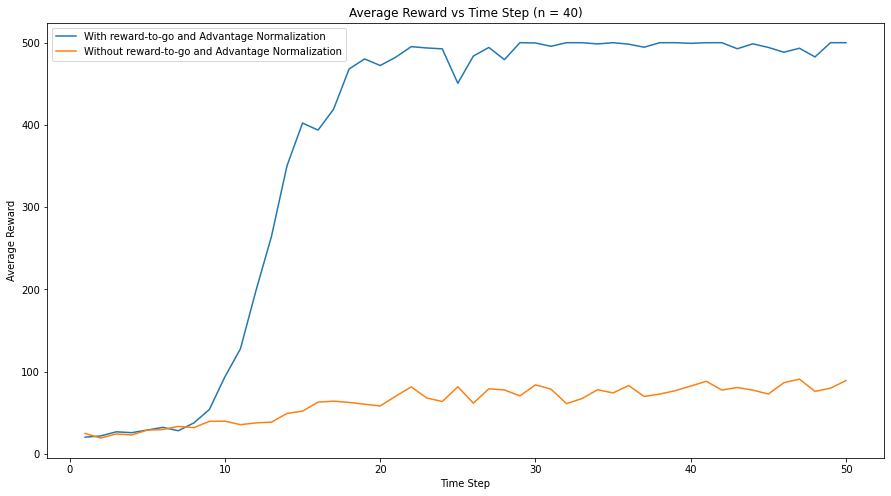

In [128]:
plt.figure(figsize=(15,8))
plt.plot(x_1,y_1,label = 'With reward-to-go and Advantage Normalization')
plt.plot(x_2,y_2,label = 'Without reward-to-go and Advantage Normalization')
plt.title('Average Reward vs Time Step (n = 40)')
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

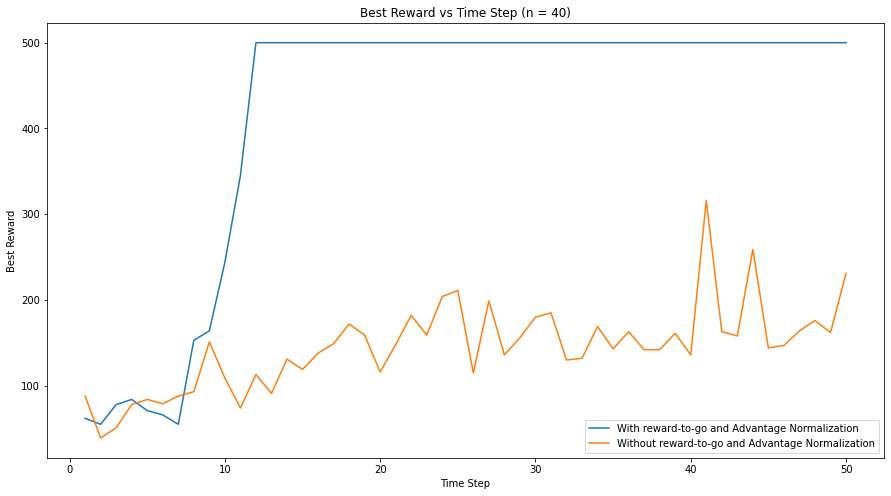

In [129]:
plt.figure(figsize=(15,8))
plt.plot(x_1,y_best_1,label = 'With reward-to-go and Advantage Normalization')
plt.plot(x_2,y_best_2,label = 'Without reward-to-go and Advantage Normalization')
plt.title('Best Reward vs Time Step (n = 40)')
plt.xlabel('Time Step')
plt.ylabel('Best Reward')
plt.legend()
plt.show()

# Policy Gradients : Lunar Lander

In [10]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape
action_size = env.action_space.n
print(state_size)
print(action_size)

(8,)
4


/home/ak0808/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [9]:
env.reset()
done = False
while not done:
    action = np.random.randint(action_size)
    _,reward,done,_ = env.step(action)
    print(reward)

-1.3158848304880735
-0.8776420000802136
-0.7219433525906414
-1.025772608351133
-0.41756387412880147
-1.4164355061576817
-0.9243878245015935
4.358627135470226
-1.4778102122598102
3.4778008838608914
-1.0402053891412493
-0.9966526161857132
-1.689184755050319
2.8010050054813123
1.1716091003363658
4.848020466855201
2.7158789888046444
-0.48841253410534935
-0.9959264615978611
-0.2122627352530617
-0.6878245163350414
0.001738509949661876
0.11798076731656806
2.5798902801020462
-0.30370451234264806
0.4072344658651741
3.4881929367722764
1.8994044359671818
-1.548762262854466
-1.3526330217652276
-1.1516255935250672
-0.6329273792323409
-0.723267234629559
-0.8434801586487584
5.068743549302053
-1.1371909731680887
4.514922977142118
-1.144754071437659
-1.239243165191482
-1.194188257895404
4.413280016602113
-1.0859655106507375
-1.0546948032558408
-1.1385721346809408
-0.8600861128767292
-0.9403558029806891
-1.0686974077269429
-1.1746473078914335
4.767323117230927
-1.16852204279283
4.6472246807704325
3.0190

 Reward for moving from the top of the screen to landing pad and zero speed is about $100$..$140$ points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional $-100$ or $+100$ points. Each leg ground contact is $+10$. Firing main engine is $-0.3$ points each frame. Solved is 200 points.

In [9]:
agent_lunarlander_1 = PGAgent1(state_size,action_size,0.99,0.001,50,50,'LunarLander')

In [10]:
scores_lunarlander_1 = agent_lunarlander_1.train(5000,True)

------- Training -------
Episode 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80


Episode 662
Episode 663
Episode 664
Episode 665
Episode 666
Episode 667
Episode 668
Episode 669
Episode 670
Episode 671
Episode 672
Episode 673
Episode 674
Episode 675
Episode 676
Episode 677
Episode 678
Episode 679
Episode 680
Episode 681
Episode 682
Episode 683
Episode 684
Episode 685
Episode 686
Episode 687
Episode 688
Episode 689
Episode 690
Episode 691
Episode 692
Episode 693
Episode 694
Episode 695
Episode 696
Episode 697
Episode 698
Episode 699
Episode 700
Episode 701
Episode 702
Episode 703
Episode 704
Episode 705
Episode 706
Episode 707
Episode 708
Episode 709
Episode 710
Episode 711
Episode 712
Episode 713
Episode 714
Episode 715
Episode 716
Episode 717
Episode 718
Episode 719
Episode 720
Episode 721
Episode 722
Episode 723
Episode 724
Episode 725
Episode 726
Episode 727
Episode 728
Episode 729
Episode 730
Episode 731
Episode 732
Episode 733
Episode 734
Episode 735
Episode 736
Episode 737
Episode 738
Episode 739
Episode 740
Episode 741
Episode 742
Episode 743
Episode 744
Epis

Episode 1319
Episode 1320
Episode 1321
Episode 1322
Episode 1323
Episode 1324
Episode 1325
Episode 1326
Episode 1327
Episode 1328
Episode 1329
Episode 1330
Episode 1331
Episode 1332
Episode 1333
Episode 1334
Episode 1335
Episode 1336
Episode 1337
Episode 1338
Episode 1339
Episode 1340
Episode 1341
Episode 1342
Episode 1343
Episode 1344
Episode 1345
Episode 1346
Episode 1347
Episode 1348
Episode 1349
Episode 1350
Episode 1351
Episode 1352
Episode 1353
Episode 1354
Episode 1355
Episode 1356
Episode 1357
Episode 1358
Episode 1359
Episode 1360
Episode 1361
Episode 1362
Episode 1363
Episode 1364
Episode 1365
Episode 1366
Episode 1367
Episode 1368
Episode 1369
Episode 1370
Episode 1371
Episode 1372
Episode 1373
Episode 1374
Episode 1375
Episode 1376
Episode 1377
Episode 1378
Episode 1379
Episode 1380
Episode 1381
Episode 1382
Episode 1383
Episode 1384
Episode 1385
Episode 1386
Episode 1387
Episode 1388
Episode 1389
Episode 1390
Episode 1391
Episode 1392
Episode 1393
Episode 1394
Episode 1395

Episode 1950
Episode 1951
Episode 1952
Episode 1953
Episode 1954
Episode 1955
Episode 1956
Episode 1957
Episode 1958
Episode 1959
Episode 1960
Episode 1961
Episode 1962
Episode 1963
Episode 1964
Episode 1965
Episode 1966
Episode 1967
Episode 1968
Episode 1969
Episode 1970
Episode 1971
Episode 1972
Episode 1973
Episode 1974
Episode 1975
Episode 1976
Episode 1977
Episode 1978
Episode 1979
Episode 1980
Episode 1981
Episode 1982
Episode 1983
Episode 1984
Episode 1985
Episode 1986
Episode 1987
Episode 1988
Episode 1989
Episode 1990
Episode 1991
Episode 1992
Episode 1993
Episode 1994
Episode 1995
Episode 1996
Episode 1997
Episode 1998
Episode 1999
Episode 2000
Episode 2001
Episode 2002
Episode 2003
Episode 2004
Episode 2005
Episode 2006
Episode 2007
Episode 2008
Episode 2009
Episode 2010
Episode 2011
Episode 2012
Episode 2013
Episode 2014
Episode 2015
Episode 2016
Episode 2017
Episode 2018
Episode 2019
Episode 2020
Episode 2021
Episode 2022
Episode 2023
Episode 2024
Episode 2025
Episode 2026

Episode 2581
Episode 2582
Episode 2583
Episode 2584
Episode 2585
Episode 2586
Episode 2587
Episode 2588
Episode 2589
Episode 2590
Episode 2591
Episode 2592
Episode 2593
Episode 2594
Episode 2595
Episode 2596
Episode 2597
Episode 2598
Episode 2599
Episode 2600
Episode 2601
Episode 2602
Episode 2603
Episode 2604
Episode 2605
Episode 2606
Episode 2607
Episode 2608
Episode 2609
Episode 2610
Episode 2611
Episode 2612
Episode 2613
Episode 2614
Episode 2615
Episode 2616
Episode 2617
Episode 2618
Episode 2619
Episode 2620
Episode 2621
Episode 2622
Episode 2623
Episode 2624
Episode 2625
Episode 2626
Episode 2627
Episode 2628
Episode 2629
Episode 2630
Episode 2631
Episode 2632
Episode 2633
Episode 2634
Episode 2635
Episode 2636
Episode 2637
Episode 2638
Episode 2639
Episode 2640
Episode 2641
Episode 2642
Episode 2643
Episode 2644
Episode 2645
Episode 2646
Episode 2647
Episode 2648
Episode 2649
Episode 2650
Episode 2651
Episode 2652
Episode 2653
Episode 2654
Episode 2655
Episode 2656
Episode 2657

Episode 3212
Episode 3213
Episode 3214
Episode 3215
Episode 3216
Episode 3217
Episode 3218
Episode 3219
Episode 3220
Episode 3221
Episode 3222
Episode 3223
Episode 3224
Episode 3225
Episode 3226
Episode 3227
Episode 3228
Episode 3229
Episode 3230
Episode 3231
Episode 3232
Episode 3233
Episode 3234
Episode 3235
Episode 3236
Episode 3237
Episode 3238
Episode 3239
Episode 3240
Episode 3241
Episode 3242
Episode 3243
Episode 3244
Episode 3245
Episode 3246
Episode 3247
Episode 3248
Episode 3249
Episode 3250
Episode 3251
Episode 3252
Episode 3253
Episode 3254
Episode 3255
Episode 3256
Episode 3257
Episode 3258
Episode 3259
Episode 3260
Episode 3261
Episode 3262
Episode 3263
Episode 3264
Episode 3265
Episode 3266
Episode 3267
Episode 3268
Episode 3269
Episode 3270
Episode 3271
Episode 3272
Episode 3273
Episode 3274
Episode 3275
Episode 3276
Episode 3277
Episode 3278
Episode 3279
Episode 3280
Episode 3281
Episode 3282
Episode 3283
Episode 3284
Episode 3285
Episode 3286
Episode 3287
Episode 3288

Episode 3843
Episode 3844
Episode 3845
Episode 3846
Episode 3847
Episode 3848
Episode 3849
Episode 3850
Episode 3851
Episode 3852
Episode 3853
Episode 3854
Episode 3855
Episode 3856
Episode 3857
Episode 3858
Episode 3859
Episode 3860
Episode 3861
Episode 3862
Episode 3863
Episode 3864
Episode 3865
Episode 3866
Episode 3867
Episode 3868
Episode 3869
Episode 3870
Episode 3871
Episode 3872
Episode 3873
Episode 3874
Episode 3875
Episode 3876
Episode 3877
Episode 3878
Episode 3879
Episode 3880
Episode 3881
Episode 3882
Episode 3883
Episode 3884
Episode 3885
Episode 3886
Episode 3887
Episode 3888
Episode 3889
Episode 3890
Episode 3891
Episode 3892
Episode 3893
Episode 3894
Episode 3895
Episode 3896
Episode 3897
Episode 3898
Episode 3899
Episode 3900
Episode 3901
Episode 3902
Episode 3903
Episode 3904
Episode 3905
Episode 3906
Episode 3907
Episode 3908
Episode 3909
Episode 3910
Episode 3911
Episode 3912
Episode 3913
Episode 3914
Episode 3915
Episode 3916
Episode 3917
Episode 3918
Episode 3919

Episode 4474
Episode 4475
Episode 4476
Episode 4477
Episode 4478
Episode 4479
Episode 4480
Episode 4481
Episode 4482
Episode 4483
Episode 4484
Episode 4485
Episode 4486
Episode 4487
Episode 4488
Episode 4489
Episode 4490
Episode 4491
Episode 4492
Episode 4493
Episode 4494
Episode 4495
Episode 4496
Episode 4497
Episode 4498
Episode 4499
Episode 4500
Episode 4501
Episode 4502
Episode 4503
Episode 4504
Episode 4505
Episode 4506
Episode 4507
Episode 4508
Episode 4509
Episode 4510
Episode 4511
Episode 4512
Episode 4513
Episode 4514
Episode 4515
Episode 4516
Episode 4517
Episode 4518
Episode 4519
Episode 4520
Episode 4521
Episode 4522
Episode 4523
Episode 4524
Episode 4525
Episode 4526
Episode 4527
Episode 4528
Episode 4529
Episode 4530
Episode 4531
Episode 4532
Episode 4533
Episode 4534
Episode 4535
Episode 4536
Episode 4537
Episode 4538
Episode 4539
Episode 4540
Episode 4541
Episode 4542
Episode 4543
Episode 4544
Episode 4545
Episode 4546
Episode 4547
Episode 4548
Episode 4549
Episode 4550

In [11]:
# Loading the final model from the folder. Just pass the number as parameter
# Testing for 50 games.
agent_lunarlander_1.load(5000)
agent_lunarlander_1.test(50,False)

------- Testing -------
	Average Score : 106.11524924179581


In [12]:
# Loading the final model from the folder. Just pass the number as parameter
# For seeing the agent in action.
agent_lunarlander_1.load(5000)
agent_lunarlander_1.test(1,True)

------- Testing -------
	Average Score : 111.36902972119223


In [13]:
agent_lunarlander_2 = PGAgent2(state_size,action_size,0.99,0.001,50,50,'LunarLander')

In [14]:
scores_lunarlander_2 = agent_lunarlander_2.train(5000,True)

------- Training -------
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episod

Episode 692
Episode 693
Episode 694
Episode 695
Episode 696
Episode 697
Episode 698
Episode 699
Episode 700
Episode 701
Episode 702
Episode 703
Episode 704
Episode 705
Episode 706
Episode 707
Episode 708
Episode 709
Episode 710
Episode 711
Episode 712
Episode 713
Episode 714
Episode 715
Episode 716
Episode 717
Episode 718
Episode 719
Episode 720
Episode 721
Episode 722
Episode 723
Episode 724
Episode 725
Episode 726
Episode 727
Episode 728
Episode 729
Episode 730
Episode 731
Episode 732
Episode 733
Episode 734
Episode 735
Episode 736
Episode 737
Episode 738
Episode 739
Episode 740
Episode 741
Episode 742
Episode 743
Episode 744
Episode 745
Episode 746
Episode 747
Episode 748
Episode 749
Episode 750
Episode 751
Episode 752
Episode 753
Episode 754
Episode 755
Episode 756
Episode 757
Episode 758
Episode 759
Episode 760
Episode 761
Episode 762
Episode 763
Episode 764
Episode 765
Episode 766
Episode 767
Episode 768
Episode 769
Episode 770
Episode 771
Episode 772
Episode 773
Episode 774
Epis

Episode 1346
Episode 1347
Episode 1348
Episode 1349
Episode 1350
Episode 1351
Episode 1352
Episode 1353
Episode 1354
Episode 1355
Episode 1356
Episode 1357
Episode 1358
Episode 1359
Episode 1360
Episode 1361
Episode 1362
Episode 1363
Episode 1364
Episode 1365
Episode 1366
Episode 1367
Episode 1368
Episode 1369
Episode 1370
Episode 1371
Episode 1372
Episode 1373
Episode 1374
Episode 1375
Episode 1376
Episode 1377
Episode 1378
Episode 1379
Episode 1380
Episode 1381
Episode 1382
Episode 1383
Episode 1384
Episode 1385
Episode 1386
Episode 1387
Episode 1388
Episode 1389
Episode 1390
Episode 1391
Episode 1392
Episode 1393
Episode 1394
Episode 1395
Episode 1396
Episode 1397
Episode 1398
Episode 1399
Episode 1400
Episode 1401
Episode 1402
Episode 1403
Episode 1404
Episode 1405
Episode 1406
Episode 1407
Episode 1408
Episode 1409
Episode 1410
Episode 1411
Episode 1412
Episode 1413
Episode 1414
Episode 1415
Episode 1416
Episode 1417
Episode 1418
Episode 1419
Episode 1420
Episode 1421
Episode 1422

Episode 1978
Episode 1979
Episode 1980
Episode 1981
Episode 1982
Episode 1983
Episode 1984
Episode 1985
Episode 1986
Episode 1987
Episode 1988
Episode 1989
Episode 1990
Episode 1991
Episode 1992
Episode 1993
Episode 1994
Episode 1995
Episode 1996
Episode 1997
Episode 1998
Episode 1999
Episode 2000
Episode 2001
Episode 2002
Episode 2003
Episode 2004
Episode 2005
Episode 2006
Episode 2007
Episode 2008
Episode 2009
Episode 2010
Episode 2011
Episode 2012
Episode 2013
Episode 2014
Episode 2015
Episode 2016
Episode 2017
Episode 2018
Episode 2019
Episode 2020
Episode 2021
Episode 2022
Episode 2023
Episode 2024
Episode 2025
Episode 2026
Episode 2027
Episode 2028
Episode 2029
Episode 2030
Episode 2031
Episode 2032
Episode 2033
Episode 2034
Episode 2035
Episode 2036
Episode 2037
Episode 2038
Episode 2039
Episode 2040
Episode 2041
Episode 2042
Episode 2043
Episode 2044
Episode 2045
Episode 2046
Episode 2047
Episode 2048
Episode 2049
Episode 2050
Episode 2051
Episode 2052
Episode 2053
Episode 2054

Episode 2609
Episode 2610
Episode 2611
Episode 2612
Episode 2613
Episode 2614
Episode 2615
Episode 2616
Episode 2617
Episode 2618
Episode 2619
Episode 2620
Episode 2621
Episode 2622
Episode 2623
Episode 2624
Episode 2625
Episode 2626
Episode 2627
Episode 2628
Episode 2629
Episode 2630
Episode 2631
Episode 2632
Episode 2633
Episode 2634
Episode 2635
Episode 2636
Episode 2637
Episode 2638
Episode 2639
Episode 2640
Episode 2641
Episode 2642
Episode 2643
Episode 2644
Episode 2645
Episode 2646
Episode 2647
Episode 2648
Episode 2649
Episode 2650
Episode 2651
Episode 2652
Episode 2653
Episode 2654
Episode 2655
Episode 2656
Episode 2657
Episode 2658
Episode 2659
Episode 2660
Episode 2661
Episode 2662
Episode 2663
Episode 2664
Episode 2665
Episode 2666
Episode 2667
Episode 2668
Episode 2669
Episode 2670
Episode 2671
Episode 2672
Episode 2673
Episode 2674
Episode 2675
Episode 2676
Episode 2677
Episode 2678
Episode 2679
Episode 2680
Episode 2681
Episode 2682
Episode 2683
Episode 2684
Episode 2685

Episode 3241
Episode 3242
Episode 3243
Episode 3244
Episode 3245
Episode 3246
Episode 3247
Episode 3248
Episode 3249
Episode 3250
Episode 3251
Episode 3252
Episode 3253
Episode 3254
Episode 3255
Episode 3256
Episode 3257
Episode 3258
Episode 3259
Episode 3260
Episode 3261
Episode 3262
Episode 3263
Episode 3264
Episode 3265
Episode 3266
Episode 3267
Episode 3268
Episode 3269
Episode 3270
Episode 3271
Episode 3272
Episode 3273
Episode 3274
Episode 3275
Episode 3276
Episode 3277
Episode 3278
Episode 3279
Episode 3280
Episode 3281
Episode 3282
Episode 3283
Episode 3284
Episode 3285
Episode 3286
Episode 3287
Episode 3288
Episode 3289
Episode 3290
Episode 3291
Episode 3292
Episode 3293
Episode 3294
Episode 3295
Episode 3296
Episode 3297
Episode 3298
Episode 3299
Episode 3300
Episode 3301
Episode 3302
Episode 3303
Episode 3304
Episode 3305
Episode 3306
Episode 3307
Episode 3308
Episode 3309
Episode 3310
Episode 3311
Episode 3312
Episode 3313
Episode 3314
Episode 3315
Episode 3316
Episode 3317

Episode 3872
Episode 3873
Episode 3874
Episode 3875
Episode 3876
Episode 3877
Episode 3878
Episode 3879
Episode 3880
Episode 3881
Episode 3882
Episode 3883
Episode 3884
Episode 3885
Episode 3886
Episode 3887
Episode 3888
Episode 3889
Episode 3890
Episode 3891
Episode 3892
Episode 3893
Episode 3894
Episode 3895
Episode 3896
Episode 3897
Episode 3898
Episode 3899
Episode 3900
Episode 3901
Episode 3902
Episode 3903
Episode 3904
Episode 3905
Episode 3906
Episode 3907
Episode 3908
Episode 3909
Episode 3910
Episode 3911
Episode 3912
Episode 3913
Episode 3914
Episode 3915
Episode 3916
Episode 3917
Episode 3918
Episode 3919
Episode 3920
Episode 3921
Episode 3922
Episode 3923
Episode 3924
Episode 3925
Episode 3926
Episode 3927
Episode 3928
Episode 3929
Episode 3930
Episode 3931
Episode 3932
Episode 3933
Episode 3934
Episode 3935
Episode 3936
Episode 3937
Episode 3938
Episode 3939
Episode 3940
Episode 3941
Episode 3942
Episode 3943
Episode 3944
Episode 3945
Episode 3946
Episode 3947
Episode 3948

Episode 4503
Episode 4504
Episode 4505
Episode 4506
Episode 4507
Episode 4508
Episode 4509
Episode 4510
Episode 4511
Episode 4512
Episode 4513
Episode 4514
Episode 4515
Episode 4516
Episode 4517
Episode 4518
Episode 4519
Episode 4520
Episode 4521
Episode 4522
Episode 4523
Episode 4524
Episode 4525
Episode 4526
Episode 4527
Episode 4528
Episode 4529
Episode 4530
Episode 4531
Episode 4532
Episode 4533
Episode 4534
Episode 4535
Episode 4536
Episode 4537
Episode 4538
Episode 4539
Episode 4540
Episode 4541
Episode 4542
Episode 4543
Episode 4544
Episode 4545
Episode 4546
Episode 4547
Episode 4548
Episode 4549
Episode 4550
Episode 4551
Episode 4552
Episode 4553
Episode 4554
Episode 4555
Episode 4556
Episode 4557
Episode 4558
Episode 4559
Episode 4560
Episode 4561
Episode 4562
Episode 4563
Episode 4564
Episode 4565
Episode 4566
Episode 4567
Episode 4568
Episode 4569
Episode 4570
Episode 4571
Episode 4572
Episode 4573
Episode 4574
Episode 4575
Episode 4576
Episode 4577
Episode 4578
Episode 4579

In [15]:
# Loading the final model from the folder. Just pass the number as parameter
# Testing for 50 games.
agent_lunarlander_2.load(5000)
agent_lunarlander_2.test(50,False)

------- Testing -------
	Average Score : 30.10525589744494


In [16]:
# Loading the final model from the folder. Just pass the number as parameter
# For seeing the agent in action.
agent_lunarlander_2.load(5000)
agent_lunarlander_2.test(1,True)

------- Testing -------
	Average Score : -46.26395437162222


In [19]:
x_1,y_1,y_best_1 = plot(scores_lunarlander_1,100)
x_2,y_2,y_best_2 = plot(scores_lunarlander_2,100)

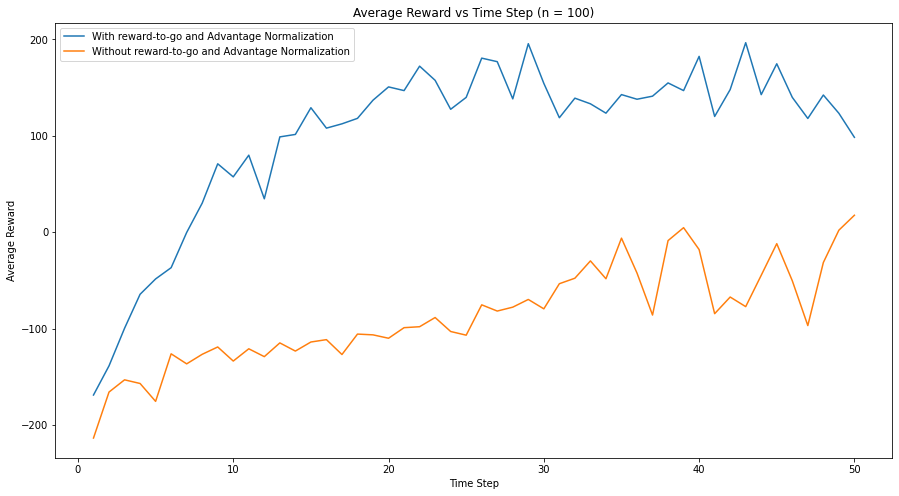

In [20]:
plt.figure(figsize=(15,8))
plt.plot(x_1,y_1,label = 'With reward-to-go and Advantage Normalization')
plt.plot(x_2,y_2,label = 'Without reward-to-go and Advantage Normalization')
plt.title('Average Reward vs Time Step (n = 100)')
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

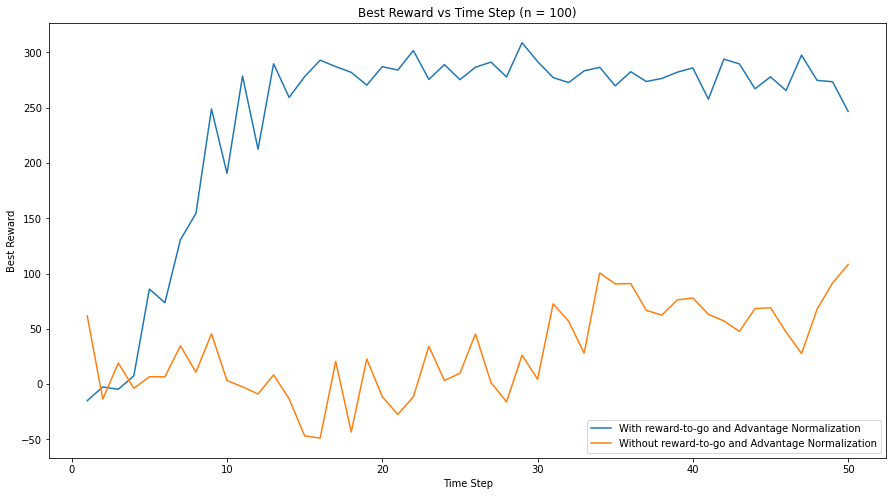

In [21]:
plt.figure(figsize=(15,8))
plt.plot(x_1,y_best_1,label = 'With reward-to-go and Advantage Normalization')
plt.plot(x_2,y_best_2,label = 'Without reward-to-go and Advantage Normalization')
plt.title('Best Reward vs Time Step (n = 100)')
plt.xlabel('Time Step')
plt.ylabel('Best Reward')
plt.legend()
plt.show()

### c)
Here the batch size depends on the length of the trajectory or number of steps in a game. So it depends on the game and a large batch size for certain games is possible which makes it really hard to train. In the above cases the batch size was at most 500 in the Cartpole and 1000 in the Lunar Lander making it possible to train without any problem.

### d)
$ \nabla_{\theta}J(\theta) = E_{\pi_{\theta}}[\Sigma_{t=0}^{\infty} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t)\psi_t ] $
where $ \psi_t = \Sigma_{t^{'}=t}^{\infty} \gamma^{t^{'}}r_{t^{'}+1} - b(s_{t^{'}}) = G_{t:\infty} - b(s_t) $

That is, We can write $ \nabla_{\theta}J(\theta) = E_{\tau \sim \pi_{\theta}(\tau)}[\nabla_{\theta}\log \pi_{\theta}(\tau)(r(\tau)-b)] $
And we know $ var[x] = E[x^2] - E[x]^2$

$ Var = E_{\tau \sim \pi_{\theta}(\tau)}[(\nabla_{\theta}\log \pi_{\theta}(\tau)(r(\tau)-b))^2] - E_{\tau \sim \pi_{\theta}(\tau)}[\nabla_{\theta}\log \pi_{\theta}(\tau)(r(\tau)-b)]^2 $

As baselines are unbiased in expectation,  $ E_{\tau \sim \pi_{\theta}(\tau)}[\nabla_{\theta}\log \pi_{\theta}(\tau)(r(\tau)-b)]^2 = E_{\tau \sim \pi_{\theta}(\tau)}[\nabla_{\theta}\log \pi_{\theta}(\tau)r(\tau)]^2 = 0$

$ \implies Var = E_{\tau \sim \pi_{\theta}(\tau)}[(\nabla_{\theta}\log \pi_{\theta}(\tau)(r(\tau)-b))^2]  $

For minimum variance, <br> <br>
$ \frac{dVar}{db} = 0 $ <br> <br>
$ \frac{dVar}{db} = \frac{d}{db}E[(\nabla_{\theta}\log \pi_{\theta}(\tau)^2(r(\tau)-b)^2] = 0 $ <br> <br>
$ \frac{d}{db}( E[(\nabla_{\theta}\log \pi_{\theta}(\tau)^2r(\tau)^2] - 2E[(\nabla_{\theta}\log \pi_{\theta}(\tau)^2]r(\tau)b + b^2E[(\nabla_{\theta}\log \pi_{\theta}(\tau)^2] ) = 0$ <br> <br>
$-2E[(\nabla_{\theta}\log \pi_{\theta}(\tau)^2r(\tau)] + 2bE[(\nabla_{\theta}\log \pi_{\theta}(\tau)^2] = 0$ <br> <br>
$ \implies b = \frac{E_{\pi_{\theta}}(\nabla_{\theta}\log \pi(a_t|s_t)^2G_{t:\infty}(\tau)}{E_{\pi_{\theta}}(\nabla_{\theta}\log \pi(a_t|s_t)^2} $
